# Google maps api and nfl teams schedule. 

*Does not take into account london games

In [61]:
import functools
import json
import os
from pprint import pprint
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests

In [2]:
pd.set_option('notebook_repr_html', False)

In [62]:
%matplotlib inline
plt.rc('figure', figsize=(15.0, 8.0))

In [ ]:
KEY = os.environ['GOOG_API_KEY']

In [4]:
URL = 'https://maps.googleapis.com/maps/api/distancematrix/json?units=imperial'

Test google maps api using Patriots/Dolphins

In [5]:
orig = '25.958056,-80.238889'
dest = '42.090833,-71.264167'

In [6]:
r = requests.get(f'{URL}&origins={orig}&destinations={dest}&key={KEY}')

In [7]:
r.status_code

In [10]:
pprint(r.json())

{'destination_addresses': ['2 Patriot Pl, Foxborough, MA 02035, USA'],
 'origin_addresses': ['347 Don Shula Dr, Miami Gardens, FL 33056, USA'],
 'rows': [{'elements': [{'distance': {'text': '1,467 mi', 'value': 2360755},
                         'duration': {'text': '21 hours 28 mins',
                                      'value': 77287},
                         'status': 'OK'}]}],
 'status': 'OK'}


In [2]:
with open('./data/nfl_stadium_coords.json') as f:
    coords = json.load(f)

In [3]:
coords[0]

{'lat': '25.958056',
 'long': '-80.238889',
 'stadium': 'sun life stadium',
 'team': 'dolphins'}

In [4]:
df = pd.DataFrame(coords)

In [7]:
df.head()

          lat         long               stadium      team
0   25.958056   -80.238889      sun life stadium  dolphins
1   42.090833   -71.264167       gilette stadium  patriots
2      42.774      -78.787  ralph wilson stadium     bills
3  40.8139642  -74.0745057       metlife stadium      jets
4   40.446667   -80.015833           heinz field  steelers

In [12]:
def _get_lat_long(df, team):
    row = df[df.team == team]
    return row.lat.iloc[0], row.long.iloc[0]

get_lat_long = functools.partial(_get_lat_long, df)

In [13]:
def parse_response(resp):
    result = resp['rows'][0]['elements'][0]['distance']['text']
    return int(re.sub(r'\D', '', result))

In [14]:
def get_miles_between(t1, t2):
    t1_lat, t1_long = get_lat_long(t1)
    t2_lat, t2_long = get_lat_long(t2)
    
    r = requests.get(f'{URL}&origins={t1_lat},{t1_long}&destinations={t2_lat},{t2_long}&key={KEY}')

    if r.status_code == requests.status_codes.codes.ok:
        return parse_response(r.json())
    return 0

In [5]:
def mkdistdata(nfl_schedule):
    for i, game in enumerate(nfl_schedule):
        distance = get_miles_between(game['home_team'], game['away_team'])
        nfl_schedule[i]['distance'] = distance
    return nfl_schedule

In [ ]:
with open('./data/nfl_schedule_2017.json') as f:
    dist_df = pd.DataFrame(mkdistdata(json.load(f)))

In [17]:
try:
    dist_df.drop('away_score', axis=1, inplace=True)
    dist_df.drop('home_score', axis=1, inplace=True)
except ValueError:
    pass

Using double the distance to account for trip back

In [18]:
dist_df['twice_distance'] = dist_df.distance * 2

In [22]:
dist_df.head()

    away_team  distance home_team  twice_distance week  year
0      chiefs    1422.0  patriots          2844.0    1  2017
1        jets     363.0     bills           726.0    1  2017
10      colts    2072.0      rams          4144.0    1  2017
100    ravens    1113.0   vikings          2226.0    7  2017
101   bengals     290.0  steelers           580.0    7  2017

In [7]:
schedule_with_distances_fn = './data/schedule_with_distances.json'

In [41]:
if not os.path.exists(schedule_with_distances_fn):
    dist_df.to_json(schedule_with_distances_fn)

In [8]:
with open(schedule_with_distances_fn) as f:
    dist_df = pd.DataFrame(json.load(f))

In [9]:
dist_df.dtypes

away_team          object
distance          float64
home_team          object
twice_distance    float64
week               object
year               object
dtype: object

In [10]:
dist_df.week = pd.to_numeric(dist_df.week)

Summary of distances

In [11]:
dist_df.twice_distance.describe()

count     256.000000
mean     2375.976562
std      1612.186575
min       224.000000
25%      1097.000000
50%      1991.000000
75%      3341.000000
max      6196.000000
Name: twice_distance, dtype: float64

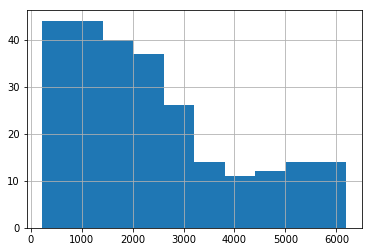

In [12]:
dist_df.twice_distance.hist()

In [13]:
totals = dist_df.groupby('away_team').twice_distance.sum()

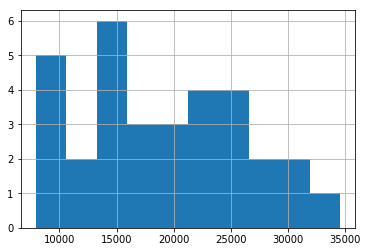

In [14]:
totals.hist()

Disparity between highest and lowest travelling teams

In [15]:
ratio = totals[totals.idxmax()] / totals[totals.idxmin()]
max_tm, min_tm = totals.idxmax().capitalize(), totals.idxmin().capitalize()
print(f'{max_tm} travel {ratio:.2f} times as many miles as the {min_tm}.')

Raiders travel 4.36 times as many miles as the Steelers.


In [53]:
def team_details(df, team):
    team_df = df[(df.home_team == team) | (df.away_team == team)].copy()
    team_df.reset_index(drop=True, inplace=True)
    team_df.loc[team_df.home_team == team, 'twice_distance'] = 0
    team_df['cum_dist'] = team_df.sort_values(by='week').twice_distance.cumsum()
    return team_df.sort_values(by='week')

Eagles travel schedule

In [62]:
eagles_df = team_details(dist_df, 'eagles')
print(eagles_df)

    away_team  distance home_team  twice_distance  week  year  cum_dist
15     eagles     129.0  redskins           258.0     1  2017     258.0
7      eagles    1123.0    chiefs          2246.0     2  2017    2504.0
11     giants     957.0    eagles             0.0     3  2017    2504.0
12     eagles    2733.0  chargers          5466.0     4  2017    7970.0
13  cardinals    2394.0    eagles             0.0     5  2017    7970.0
14     eagles     532.0  panthers          1064.0     6  2017    9034.0
0    redskins     129.0    eagles             0.0     7  2017    9034.0
1       49ers    2907.0    eagles             0.0     8  2017    9034.0
2     broncos    1732.0    eagles             0.0     9  2017    9034.0
3      eagles    1480.0   cowboys          2960.0    11  2017   11994.0
4       bears     763.0    eagles             0.0    12  2017   11994.0
5      eagles    2831.0  seahawks          5662.0    13  2017   17656.0
6      eagles    2720.0      rams          5440.0    14  2017   

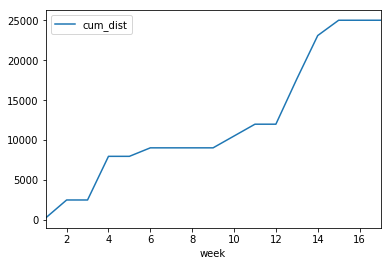

In [61]:
eagles_df.plot(x='week', y='cum_dist')

In [24]:
grouped = dist_df.groupby('away_team')

In [34]:
full_season = pd.DataFrame({'week': np.arange(1, 18)})
partial_season = pd.DataFrame({'week': [1, 3, 6, 8, 4, 9, 15],
                               'values': [0, 1, 2, 3, 4, 5, 6]})

In [96]:
res = partial_season.merge(full_season, on='week', how='right').sort_values(by='week')

In [97]:
res.ffill()

    values  week
0      0.0     1
7      0.0     2
1      1.0     3
4      4.0     4
8      4.0     5
2      2.0     6
9      2.0     7
3      3.0     8
5      5.0     9
10     5.0    10
11     5.0    11
12     5.0    12
13     5.0    13
14     5.0    14
6      6.0    15
15     6.0    16
16     6.0    17

In [71]:
def f(group):
    merged = group.merge(pd.DataFrame({'week': np.arange(1, 18)}), on='week', how='outer')
    sorted_by_week = merged[['twice_distance', 'week']].sort_values(by='week')
    return pd.DataFrame({
        'week': sorted_by_week.week,
        'cumdist': sorted_by_week.twice_distance.cumsum()
    }).ffill()

cumdists_per_team = grouped.apply(f)

In [72]:
cumdists_per_team.loc['eagles', :]

    cumdist  week
7     258.0     1
3    2504.0     2
8    2504.0     3
5    7970.0     4
9    7970.0     5
6    9034.0     6
10   9034.0     7
11   9034.0     8
12   9034.0     9
13   9034.0    10
0   11994.0    11
14  11994.0    12
1   17656.0    13
2   23096.0    14
4   25012.0    15
15  25012.0    16
16  25012.0    17

In [86]:
cumdists_per_team.index.levels[0]

Index(['49ers', 'bears', 'bengals', 'bills', 'broncos', 'browns', 'buccaneers',
       'cardinals', 'chargers', 'chiefs', 'colts', 'cowboys', 'dolphins',
       'eagles', 'falcons', 'giants', 'jaguars', 'jets', 'lions', 'packers',
       'panthers', 'patriots', 'raiders', 'rams', 'ravens', 'redskins',
       'saints', 'seahawks', 'steelers', 'texans', 'titans', 'vikings'],
      dtype='object', name='away_team')

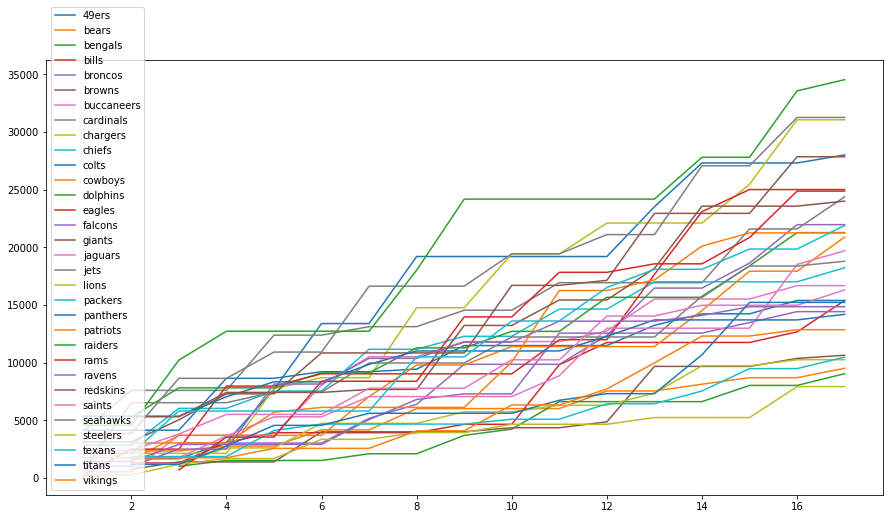

In [93]:
for label in cumdists_per_team.index.levels[0]:
    lab_df = cumdists_per_team.loc[label]
    plt.plot(lab_df.week, lab_df.cumdist, label=label)
plt.legend(loc=3)